In [1]:
import random
import scipy
import math
import sklearn
from alepython import ale_plot
from scipy.stats import linregress
from scipy import stats
from glob import glob
import seaborn as sns
import pickle5 as pickle
from rfpimp import *
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics import matthews_corrcoef

# 1. Import training dataset

In [12]:
with open('file/feat_mean.pkl', 'rb') as handle:
    feature_ = pickle.load(handle)
    
with open('file/ave_hsa.pkl', 'rb') as handle:
    hsa_ = pickle.load(handle)
    
with open('file/name_list.pkl', 'rb') as handle:
    name_list = pickle.load(handle)

fl = pd.ExcelFile("file/GRN.xls")
type_ = fl.parse(0)[["model_name (alias)","types"]].drop_duplicates().query("types == 'ONCO'")["model_name (alias)"].tolist()
col_ = ['ABL1', 'ABL2', 'AKT_i', 'APC', 'AXIN1', 'BAD', 'BAK1', 'BAX', 'BCL2', 'BCLXL', 'BID', 'BIM', 'CASP3', 'CASP8', 'CASP9', 'CDKN2A', 'CEBPB', 'CREB1', 'CTNNB1', 'CYCLIN_D_c', 'CYCS', 'DC', 'DLL_i', 'DVL1', 'E2F1', 'EGF', 'EGFR', 'EIF4E', 'ERK_i', 'ES', 'ESR1', 'FADD', 'FAS', 'FASLG', 'FOXO1', 'FOXO3', 'FZD3', 'GATA3', 'GRB2', 'GRB7', 'GSK3B', 'HER2', 'HER3', 'HES1', 'HEY1', 'HRAS', 'HSP90AA1', 'IGF1', 'IGF1R', 'IL1B', 'IL6', 'IL6R', 'IL8', 'INS', 'INSR', 'IRS1', 'IVEBP1', 'JAK2', 'JUN', 'KMT2D', 'KRT14', 'LATS1', 'LCK', 'MAPK8', 'MCL1', 'MDM2', 'MEK_i', 'MTORC1_c', 'MTORC2_c', 'MYC', 'MYOD1', 'MYOG', 'NCID', 'NEDD4L', 'NF1', 'NF2', 'NFKB1', 'NOS3', 'NOTCH1', 'NRG1', 'P21', 'P53', 'PAK1', 'PAK2', 'PAX7', 'PDPK1', 'PG', 'PGR', 'PI3K_c', 'PIM', 'PIP3', 'PPARG', 'PRB', 'PRKAA2', 'PRKACA', 'PTEN', 'RAC1', 'RAF1', 'RAS_i', 'RELA', 'RHEB', 'RND1', 'S6K1', 'SGK1', 'SOS1', 'SRC', 'STAT1', 'STAT3', 'STAT5', 'STK11', 'TCF4', 'TEAD1', 'TRADD', 'TSC2', 'TWIST1', 'WNT1', 'YAP1']




In [3]:
dat = pd.read_csv("file/drugcomb_RF_574.csv")
cl_index = dat[["synergy_hsa","cell_line_name"]].replace("BT-549", 1).replace("MDA-MB-468", 2).replace("MDA-MB-231", 3).replace("MCF7", 4).replace("T-47D",5)
cl_index["hsa_cat"] = np.where(cl_index["synergy_hsa"]>0,1,0)
cl_index["stratify_index"] = cl_index["cell_line_name"].astype(str) + cl_index["hsa_cat"].astype(str)
group_ = cl_index["stratify_index"].to_list()
print(cl_index)

     synergy_hsa  cell_line_name  hsa_cat stratify_index
0       3.705799               5        1             51
1       9.748245               5        1             51
2      -0.393017               2        0             20
3      -1.682197               5        0             50
4       0.634869               2        1             21
..           ...             ...      ...            ...
569     4.626205               2        1             21
570    -2.368887               5        0             50
571    -7.836692               2        0             20
572     7.027783               5        1             51
573    -0.949728               1        0             10

[574 rows x 4 columns]


# 2. Train model

In [4]:
RF = RandomForestRegressor(random_state=42,oob_score=True,n_jobs=-1)

model_01 = {
    'max_depth': 4,
    'max_samples': 0.7,
    'ccp_alpha': 0.5,
    'min_samples_leaf': 16,
    'min_samples_split': 32,
    'n_estimators': 2000}

model_02 = {
    'max_depth': 5,
    'max_samples': 0.7,
    'ccp_alpha': 0.5,
    'min_samples_leaf': 16,
    'min_samples_split': 24,
    'n_estimators': 2000}

model_03 = {
    'max_depth': 5,
    'max_samples': 0.7,
    'ccp_alpha': 0.5,
    'min_samples_leaf': 16,
    'min_samples_split': 16,
    'n_estimators': 2000}

model_04 = {
    'max_depth': 4,
    'max_samples': 0.7,
    'ccp_alpha': 0.7,
    'min_samples_leaf': 16,
    'min_samples_split': 24,
    'n_estimators': 2000}

model_05 = {
    'max_depth': 3,
    'max_samples': 0.7,
    'ccp_alpha': 0.5,
    'min_samples_leaf': 16,
    'min_samples_split': 32,
    'n_estimators': 2000}


ensemble_list = [model_01,model_02,model_03,model_04,model_05]

In [5]:

imp_list = [] # feature importance score
raw_outer = [] # raw_score from 5 cv
res_all  = []

fold_out= 5
skf_outer = StratifiedKFold(n_splits=fold_out,random_state=42,shuffle=True)
group_ = np.array(cl_index["stratify_index"].to_list())

"""
outer fold
"""

for i, (train_outer, test_outer) in enumerate(skf_outer.split(group_, group_)):
    
    #iterating through five models
    best_param = ensemble_list[i]
    print(best_param)

    #spliting data based on outer fold 
    Xtrain_cv,ytrain_cv = feature_[train_outer], hsa_[train_outer]
    Xtest_cv,ytest_cv = feature_[test_outer], hsa_[test_outer]

    #stratifing inner fold from split outer fold
    fold_in = 5
    skf_inner = StratifiedKFold(n_splits=fold_in,random_state=42,shuffle=True)
    group_inner = [group_[__inner__] for __inner__ in train_outer]
    
    """
    inner fold
    """
    cv_outer = []
    cv_inner_raw = []
    
    for j, (train_in, val_in) in enumerate(skf_inner.split(group_inner,group_inner)):

        Xtrain_in,ytrain_in = Xtrain_cv[train_in], ytrain_cv[train_in]
        Xval_in,yval_in = Xtrain_cv[val_in], ytrain_cv[val_in]
        
        """
        1. configure the best model
        """
        
        best_model = RF.set_params(**best_param)
        best_model.fit(Xtrain_in,ytrain_in)

        """
        2. evaluate feature importance from out-of-bag sampling
        """
        imp = permutation_importances(best_model, pd.DataFrame(Xtrain_in,columns=col_), ytrain_in,oob_regression_r2_score)
        imp_df_ = imp.reset_index()
        imp_df_["inner"] = j
        imp_df_["outer"] = i
        imp_list.append(imp_df_)
        
        """
        3. summarize the model performance of training and validating fold
        """
        pred_train = best_model.predict(Xtrain_in)
        pred_validation = best_model.predict(Xval_in)
        score_train_in = scipy.stats.pearsonr(ytrain_in,pred_train)[0]
        score_validation_in = scipy.stats.pearsonr(yval_in,pred_validation)[0]
        
        """
        4. collect raw predictions
        """
        df_val = pd.DataFrame([pred_validation,yval_in]).T
        df_val.columns = ["prediction","experiment"]
        df_val["type"] = "validation"

        df_train = pd.DataFrame([pred_train,ytrain_in]).T
        df_train.columns = ["prediction","experiment"]
        df_train["type"] = "training"
        combine_raw = pd.concat([df_train,df_val])
        combine_raw["inner_fold"] = j
        

        """
        5. append (3) and (4) into list
        """
        cv_inner_raw.append(combine_raw)
        cv_outer.append([i,j,score_train_in,score_validation_in])
        
        
    """
    6. Summarize the prediction of the outer fold to (5)
    """
    
    #6.1 combine predicted testing fold with (5)
    res_ = pd.DataFrame(cv_outer,columns=["round","folder_inner","training","validating"])
    best_model = RF.set_params(**best_param)
    best_model.fit(Xtrain_cv,ytrain_cv)
    pred_test = best_model.predict(Xtest_cv)    
    score_test = scipy.stats.pearsonr(ytest_cv,pred_test)[0]
    res_["testing"] = score_test

    #6.2 curate the optimal hyperparameter into table
    df_p = pd.DataFrame(best_param.items()).T
    df_p_2 = df_p.iloc[1:,:]
    df_p_2.columns = df_p.iloc[0,:]
    df_param = pd.concat([df_p_2]*fold_in)
    
    #6.3 concatenate 6.1 and 6.2 as a single dataframe
    res_final = pd.concat([res_.reset_index(),df_param.reset_index()],axis=1)
    res_all.append(res_final)    
    
    """
    7. Summarize as the raw score
    """

    df_test = pd.DataFrame([pred_test,ytest_cv]).T
    df_test.columns = ["prediction","experiment"]
    df_test["type"] = 'testing'
    df_test["inner_fold"] = 9999

    df_raw = pd.concat(cv_inner_raw)
    df_raw_ = pd.concat([df_raw,df_test])
    df_raw_["outer_fold"] = i
    raw_outer.append(df_raw_)


pdf = pd.concat(res_all)
pdf.to_csv("result/res_RF.csv")
pd.concat(raw_outer).to_csv("result/raw_score_RF.csv")


{'max_depth': 4, 'max_samples': 0.7, 'ccp_alpha': 0.5, 'min_samples_leaf': 16, 'min_samples_split': 32, 'n_estimators': 2000}
{'max_depth': 5, 'max_samples': 0.7, 'ccp_alpha': 0.5, 'min_samples_leaf': 16, 'min_samples_split': 24, 'n_estimators': 2000}
{'max_depth': 5, 'max_samples': 0.7, 'ccp_alpha': 0.5, 'min_samples_leaf': 16, 'min_samples_split': 16, 'n_estimators': 2000}
{'max_depth': 4, 'max_samples': 0.7, 'ccp_alpha': 0.7, 'min_samples_leaf': 16, 'min_samples_split': 24, 'n_estimators': 2000}
{'max_depth': 3, 'max_samples': 0.7, 'ccp_alpha': 0.5, 'min_samples_leaf': 16, 'min_samples_split': 32, 'n_estimators': 2000}


# 3. Save model

In [6]:
### SAVE MODEL #####
param = pd.read_csv("result/res_RF.csv")
RF = RandomForestRegressor(random_state=42,oob_score=True,n_jobs=-1)
param_list=[]
for p_ in range(5):
    prep_df = param.query("round == @p_").iloc[:,8:].drop_duplicates().T.reset_index()
    prep_df.columns = ["param_","value"]
    param_dict = dict(zip(prep_df.param_, prep_df.value))
    param_dict["n_estimators"]=int(param_dict["n_estimators"])
    param_dict["max_depth"]=int(param_dict["max_depth"])
    param_dict["min_samples_leaf"]=int(param_dict["min_samples_leaf"])
    param_dict["min_samples_split"]=int(param_dict["min_samples_split"])
    param_list.append(param_dict)
    
param_list = [i for n, i in enumerate(param_list) if i not in param_list[n + 1:]]


value_list = []
cnt=0
for para in param_list:
    print(para)
    RF = RandomForestRegressor(random_state=42,oob_score=True,n_jobs=-1)
    best_model = RF.set_params(**para)
    best_model.fit(feature_,hsa_)
    pickle.dump(best_model, open('result/refitted_RF_'+str(cnt), 'wb'))
    cnt = cnt + 1


{'max_depth': 4, 'max_samples': 0.7, 'ccp_alpha': 0.5, 'min_samples_leaf': 16, 'min_samples_split': 32, 'n_estimators': 2000}
{'max_depth': 5, 'max_samples': 0.7, 'ccp_alpha': 0.5, 'min_samples_leaf': 16, 'min_samples_split': 24, 'n_estimators': 2000}
{'max_depth': 5, 'max_samples': 0.7, 'ccp_alpha': 0.5, 'min_samples_leaf': 16, 'min_samples_split': 16, 'n_estimators': 2000}
{'max_depth': 4, 'max_samples': 0.7, 'ccp_alpha': 0.7, 'min_samples_leaf': 16, 'min_samples_split': 24, 'n_estimators': 2000}
{'max_depth': 3, 'max_samples': 0.7, 'ccp_alpha': 0.5, 'min_samples_leaf': 16, 'min_samples_split': 32, 'n_estimators': 2000}


# 4. Extract feature importance from out-of-bag sampling

In [7]:
pd.concat(imp_list).to_csv("result/feat_raw_imp.csv")
pd.read_csv("result/feat_raw_imp.csv").groupby(["Feature","outer"]).mean().reset_index().to_csv("feat_imp.csv")

In [10]:
df3 = pd.read_csv("result/feat_raw_imp.csv").groupby(["Feature"]).mean().sort_values(by="Importance",ascending=False).head(n=30).reset_index()
fim = df3.Feature.tolist()
dfe = pd.DataFrame(feature_,columns=col_)[fim]
dfe["hsa"] = hsa_
dfe["index"] = dfe.index

In [13]:
mdf = dfe.melt(id_vars=["hsa","index"])
mdf["hsa"] = np.where(mdf["hsa"] > 0,1,0)
mdf2 = mdf.copy()
mdf2["cat"] = np.where(mdf2["variable"].isin(type_),"ONCO","TMR")
mdf2["hsa"] = np.where(mdf2["hsa"]==0,"Antagonistic group","Synergistic group")
mdf2.groupby(["hsa","variable","cat"]).mean().reset_index().to_csv("global.csv")

In [ ]:
cnt = 0

for i in range(5):
    
    slope_ = []

    for g_ in col_:
        print(cnt)
        best_model0 = pickle.load(open('result/refitted_RF_'+str(i), 'rb'))
        plt_=ale_plot(best_model0,pd.DataFrame(feature_,columns=col_), g_, monte_carlo=True)
        y_=plt_.get_lines()[0].get_xydata()[:,1]
        x_=plt_.get_lines()[0].get_xydata()[:,0]
        slope, intercept, r_value, p_value, std_err = linregress(x_, y_)

        df_1 = pd.DataFrame([x_,y_]).T
        df_1.columns = ["X","Y"]
        df_1["slope"] = slope
        df_1["gene"] = g_
        slope_.append(df_1)
        cnt+=0

    pd.concat(slope_).to_csv('result/ALE'+str(i)+'.csv')

# 5. Visualize model's performance

In [16]:
def cal_perf(g):
   
    experiment_score = g['experiment'].to_numpy()
    predicted_score  = g['prediction'].to_numpy()
    
    pred_cat_ = [0 if i <= 0 else 1 for i in predicted_score]
    obs_cat_ = [0 if i <= 0 else 1 for i in experiment_score]
    
    tn, fp, fn, tp = metrics.confusion_matrix(obs_cat_,pred_cat_).ravel()
    norm_obs = sklearn.preprocessing.minmax_scale(predicted_score, feature_range=(0,1))
    fpr, tpr, thresholds = metrics.roc_curve(obs_cat_,norm_obs)
    
    mse = mean_squared_error(experiment_score,predicted_score)
    spec = tn/(tn+fp)
    sen = tp/(tp+fn)
    fpr_ = fp/(fp+tn)
    AUC_ = sklearn.metrics.auc(fpr, tpr)
    MCC = matthews_corrcoef(obs_cat_, pred_cat_)
    
    Pearson = np.corrcoef(experiment_score, predicted_score)[0, 1]
    
    return pd.Series(dict(Pearsoncorrelatioin=Pearson, MSE = mse, AUC=AUC_, Sensitivity=sen, Specificity=spec,MCC=MCC,FPR=fpr_))


In [17]:
def cal_perf2(x,y):
    
    cor_ = np.corrcoef(x, y)[0,1]
    
    ###

    pred_cat_ = [0 if i <= 0 else 1 for i in y]
    obs_cat_ = [0 if i <= 0 else 1 for i in x]
    tn, fp, fn, tp = metrics.confusion_matrix(obs_cat_,pred_cat_).ravel()
    norm_obs = sklearn.preprocessing.minmax_scale(y, feature_range=(0,1))
    fpr, tpr, thresholds = metrics.roc_curve(obs_cat_,norm_obs)

    spec = tn/(tn+fp)
    sen = tp/(tp+fn)
    fpr_ = fp/(fp+tn)
    AUC_ = sklearn.metrics.auc(fpr, tpr)

    res = pd.DataFrame([cor_,AUC_,sen,spec,fpr_],columns=["value"])
    res["index"] = ["correlation","AUC","Sensitivity","Specficity","FPR"]
    return res


<AxesSubplot:xlabel='variable', ylabel='value'>

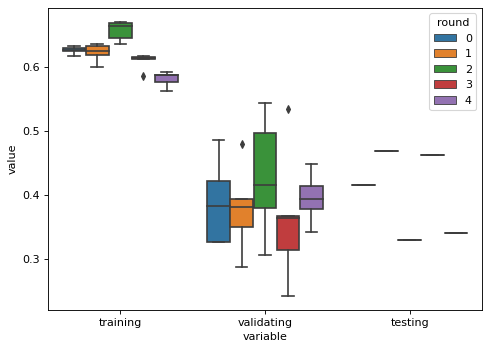

In [18]:
import seaborn as sns
from matplotlib.pyplot import figure
figure(figsize=(7, 5), dpi=80)
#RF_param/res_RF_hightree0.csv
plot_ = pd.read_csv("result/res_RF.csv")[["round","folder_inner","training","validating","testing"]].melt(id_vars=["round","folder_inner"])
sns.boxplot(data=plot_, x="variable", y="value",hue="round")

In [19]:
from sklearn import metrics

perf =pd.read_csv("result/raw_score_RF.csv").iloc[:,1:]
perf_ = perf.groupby(["type","outer_fold","inner_fold"]).apply(lambda x: cal_perf2(x.experiment,x.prediction)).reset_index()
perf_2 = perf_.groupby(["type","index"]).mean().reset_index()[["type","index","value"]]
pd.pivot_table(perf_2, values='value', index='index',columns='type')[["training","validation","testing"]]

type,training,validation,testing
index,,,
AUC,0.784068,0.679427,0.673697
FPR,0.478455,0.581142,0.608824
Sensitivity,0.857944,0.795088,0.810268
Specficity,0.521545,0.418858,0.391176
correlation,0.619670,0.391151,0.403406


In [21]:
dat_ = []
for i in ["training","validation","testing"]:
    cc=perf.query("type == @i").groupby("outer_fold").apply(cal_perf).agg(["mean","std"])
    cc["type"] = i
    dat_.append(cc)
    
plt_ = pd.concat(dat_).reset_index()
plt_

,index,Pearsoncorrelatioin,MSE,AUC,Sensitivity,Specificity,MCC,FPR,type
0,mean,0.619566,29.345511,0.782381,0.857979,0.521555,0.407661,0.478445,training
1,std,0.027367,0.827300,0.010810,0.021191,0.017565,0.026035,0.017565,training
2,mean,0.381491,36.764534,0.676212,0.795088,0.418573,0.231749,0.581427,validation
3,std,0.027972,0.896662,0.009667,0.011141,0.019264,0.017774,0.019264,validation
4,mean,0.403406,36.337025,0.673697,0.810268,0.391176,0.224943,0.608824,testing
5,std,0.065902,3.556351,0.060753,0.063808,0.049180,0.121585,0.049180,testing


# 6. Test overfitting between validating and testing fold 

In [22]:
import scipy.stats as ss
dat_ = []
for i in ["training","validation","testing"]:
    cc=perf.query("type == @i").groupby("outer_fold").apply(cal_perf)
    cc["type"] = i
    dat_.append(cc)

In [26]:
xall=pd.concat(dat_).query("type != 'training'")

In [27]:

pv = []
for i in range(7):
    xall2 = xall.iloc[:,[i,7]]
    name_ = xall2.columns[0]
    values_per_group = [col for col_name, col in xall2.groupby("type")[name_]]
    ss_ = ss.ranksums(*values_per_group)[1]
    print(name_+"   p-value:   "+str(round(ss_,3)))

Pearsoncorrelatioin   p-value:   0.754
MSE   p-value:   0.917
AUC   p-value:   0.602
Sensitivity   p-value:   0.917
Specificity   p-value:   0.347
MCC   p-value:   0.917
FPR   p-value:   0.347
